# LSTM Text Generation - Character Level
## Generative AI Engineer Task

This notebook implements a character-level LSTM model for text generation using TensorFlow/Keras.

**Dataset:** Shakespeare's Complete Works from Project Gutenberg

## 1. Import Libraries and Setup

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import string
import requests
from collections import Counter
import json
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.19.0
GPU Available: False


## 2. Configuration and Hyperparameters

In [58]:
SEQUENCE_LENGTH = 20
BATCH_SIZE = 128
EPOCHS = 20
EMBEDDING_DIM = 128
LSTM_UNITS = 128
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.01
VALIDATION_SPLIT = 0.1
USE_SUBSET = True
SUBSET_SIZE = 10000

print("Configuration:")
print(f"  Sequence Length: {SEQUENCE_LENGTH}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Embedding Dim: {EMBEDDING_DIM}")
print(f"  LSTM Units: {LSTM_UNITS}")

Configuration:
  Sequence Length: 20
  Batch Size: 128
  Epochs: 20
  Embedding Dim: 128
  LSTM Units: 128


In [48]:
SEQUENCE_LENGTH = 50      # ↑ More context (was 20)
BATCH_SIZE = 128          # ✓ Good
EPOCHS = 2               # ↑ More learning (was 10)
EMBEDDING_DIM = 128       # ✓ Good
LSTM_UNITS = 256          # ↑ More capacity (was 128)
DROPOUT_RATE = 0.2        # ✓ Good
LEARNING_RATE = 0.002     # ↓ More stable (was 0.01)
VALIDATION_SPLIT = 0.1    # ✓ Good
USE_SUBSET = True
SUBSET_SIZE = 100000      # ↑ More data (was 10000)

## 3. Data Loading and Preprocessing

In [59]:
def load_data(url=None, filepath=None):
    if filepath:
        print(f"Loading text from {filepath}...")
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    else:
        if url is None:
            url = "https://www.gutenberg.org/files/100/100-0.txt"
        print(f"Downloading text from Project Gutenberg...")
        response = requests.get(url)
        text = response.text

    print(f"✓ Text loaded successfully")
    print(f"  Total characters: {len(text):,}")
    return text

raw_text = load_data()

✓ Text loaded successfully
  Total characters: 5,359,444


In [60]:
print("Raw Text Preview (first 500 characters):")
print(raw_text[:500])

Raw Text Preview (first 500 characters):
*** START OF THE PROJECT GUTENBERG EBOOK 100 ***




The Complete Works of William Shakespeare

by William Shakespeare




                    Contents

    THE SONNETS
    ALL’S WELL THAT ENDS WELL
    THE TRAGEDY OF ANTONY AND CLEOPATRA
    AS YOU LIKE IT
    THE COMEDY OF ERRORS
    THE TRAGEDY OF CORIOLANUS
    CYMBELINE
    THE TRAGEDY OF HAMLET, PRINCE OF DENMARK
    THE FIRST PART OF KING HENRY THE FOURTH
    THE SECOND PART OF KING HENRY THE FOURTH
    THE LIFE OF KING HENRY THE FIFTH
  


In [61]:
def preprocess_text(text):
    text = text.lower()
    allowed_chars = set(string.ascii_lowercase + string.digits + ' .,!?;:\n\'-')
    text = ''.join(c for c in text if c in allowed_chars)
    text = ' '.join(text.split())
    return text

if USE_SUBSET:
    raw_text = raw_text[:SUBSET_SIZE]
    print(f"Using subset of {SUBSET_SIZE:,} characters")

text = preprocess_text(raw_text)
print(f"\n✓ Text preprocessed")
print(f"  Final length: {len(text):,} characters")
print(f"\nPreprocessed Preview:")
print(text[:300])

Using subset of 10,000 characters

✓ Text preprocessed
  Final length: 9,351 characters

Preprocessed Preview:
start of the project gutenberg ebook 100 the complete works of william shakespeare by william shakespeare contents the sonnets alls well that ends well the tragedy of antony and cleopatra as you like it the comedy of errors the tragedy of coriolanus cymbeline the tragedy of hamlet, prince of denmark


## 4. Vocabulary Creation

In [62]:
def create_vocabulary(text):
    chars = sorted(set(text))
    vocab_size = len(chars)
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return char_to_idx, idx_to_char, vocab_size

char_to_idx, idx_to_char, vocab_size = create_vocabulary(text)

print(f"✓ Vocabulary created")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Characters: {''.join(list(char_to_idx.keys()))}")

✓ Vocabulary created
  Vocabulary size: 43
  Characters:  ,-.0123456789:;?abcdefghijklmnopqrstuvwxyz


In [63]:
char_counts = Counter(text)
top_chars = char_counts.most_common(20)

print("Top 20 most frequent characters:")
for char, count in top_chars:
    char_display = repr(char) if char in ['\n', ' '] else char
    print(f"  {char_display}: {count:,} ({count/len(text)*100:.2f}%)")

Top 20 most frequent characters:
  ' ': 1,688 (18.05%)
  e: 1,002 (10.72%)
  t: 768 (8.21%)
  h: 555 (5.94%)
  o: 553 (5.91%)
  s: 519 (5.55%)
  a: 459 (4.91%)
  n: 442 (4.73%)
  i: 431 (4.61%)
  r: 415 (4.44%)
  l: 328 (3.51%)
  d: 286 (3.06%)
  u: 264 (2.82%)
  y: 196 (2.10%)
  w: 190 (2.03%)
  f: 187 (2.00%)
  m: 166 (1.78%)
  g: 145 (1.55%)
  ,: 145 (1.55%)
  c: 138 (1.48%)


## 5. Prepare Training Sequences

In [64]:
def prepare_sequences(text, char_to_idx, sequence_length, vocab_size):
    sequences = []
    next_chars = []

    print("Creating sequences...")
    for i in range(len(text) - sequence_length):
        sequences.append(text[i:i + sequence_length])
        next_chars.append(text[i + sequence_length])

    num_sequences = len(sequences)
    print(f"  Created {num_sequences:,} sequences")

    print("Encoding sequences...")
    X = np.zeros((num_sequences, sequence_length), dtype=np.int32)
    y = np.zeros((num_sequences, vocab_size), dtype=np.float32)

    for i, seq in enumerate(sequences):
        for j, char in enumerate(seq):
            X[i, j] = char_to_idx[char]
        y[i, char_to_idx[next_chars[i]]] = 1

        if (i + 1) % 50000 == 0:
            print(f"  Encoded {i+1:,}/{num_sequences:,} sequences")

    return X, y

X, y = prepare_sequences(text, char_to_idx, SEQUENCE_LENGTH, vocab_size)

print(f"\n✓ Sequences prepared")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")

Creating sequences...
  Created 9,331 sequences
Encoding sequences...

✓ Sequences prepared
  X shape: (9331, 20)
  y shape: (9331, 43)


In [65]:
example_idx = 100
example_seq = ''.join([idx_to_char[idx] for idx in X[example_idx]])
example_next = idx_to_char[np.argmax(y[example_idx])]

print("Example training sequence:")
print(f"  Input:  '{example_seq}'")
print(f"  Output: '{example_next}'")

Example training sequence:
  Input:  'peare contents the s'
  Output: 'o'


## 6. Build LSTM Model

In [66]:
def build_model(vocab_size, embedding_dim, lstm_units, sequence_length, dropout_rate, learning_rate):
    model = keras.Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=sequence_length,
            name='embedding'
        ),
        layers.LSTM(
            lstm_units,
            return_sequences=True,
            dropout=dropout_rate,
            name='lstm_1'
        ),
        layers.LSTM(
            lstm_units,
            dropout=dropout_rate,
            name='lstm_2'
        ),
        layers.Dense(vocab_size, activation='softmax', name='output')
    ], name='LSTM_Text_Generator')

    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model

model = build_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    lstm_units=LSTM_UNITS,
    sequence_length=SEQUENCE_LENGTH,
    dropout_rate=DROPOUT_RATE,
    learning_rate=LEARNING_RATE
)

print("✓ Model built successfully\n")
model.summary()

✓ Model built successfully



Model: "LSTM_Text_Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 7. Train the Model

In [67]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_lstm_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("Starting training...\n")

history = model.fit(
    X, y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Starting training...

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.1665 - loss: 3.0497
Epoch 1: val_loss improved from inf to 2.63095, saving model to best_lstm_model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step - accuracy: 0.1671 - loss: 3.0468 - val_accuracy: 0.2612 - val_loss: 2.6310
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.3143 - loss: 2.4334
Epoch 2: val_loss improved from 2.63095 to 2.37424, saving model to best_lstm_model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.3145 - loss: 2.4324 - val_accuracy: 0.3148 - val_loss: 2.3742
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.3630 - loss: 2.2022
Epoch 3: val_loss improved from 2.37424 to 2.24055, saving model to best_lstm_model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.3631 - loss: 2.2018 - val_accuracy: 0.3630 - val_loss: 2.2406
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.4047 - loss: 2.0623
Epoch 4: val_l

## 8. Visualize Training History

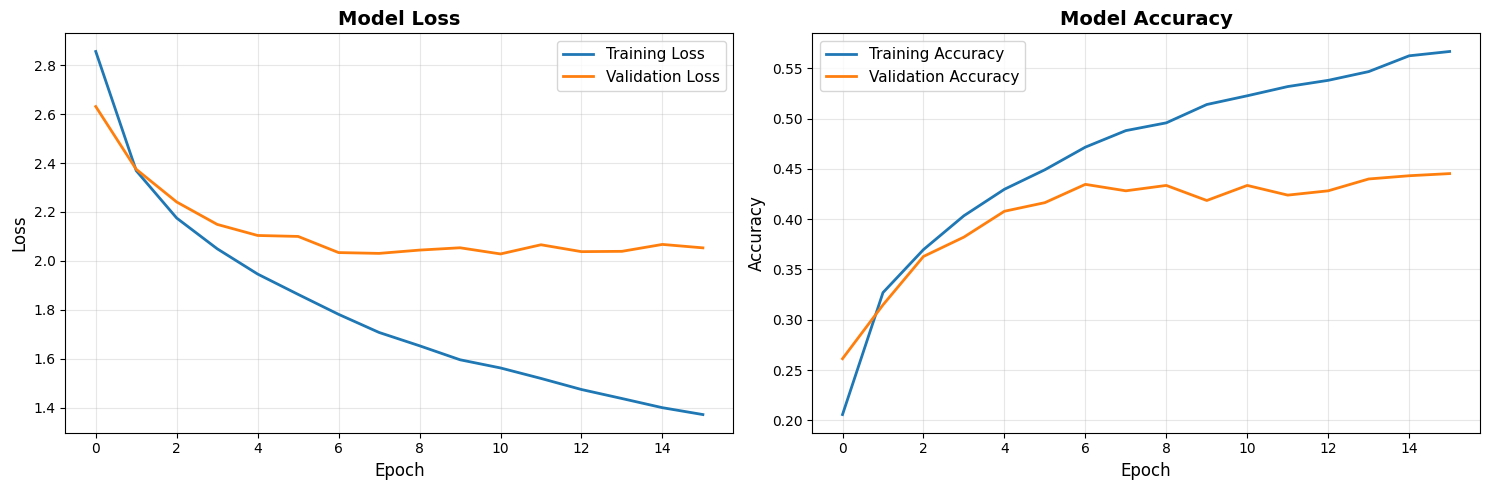

Final Training Metrics:
  Training Loss: 1.3712
  Validation Loss: 2.0530
  Training Accuracy: 0.5669
  Validation Accuracy: 0.4454


In [68]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Final Training Metrics:")
print(f"  Training Loss: {history.history['loss'][-1]:.4f}")
print(f"  Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"  Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

## 9. Text Generation Functions

In [69]:
def generate_text(model, seed_text, char_to_idx, idx_to_char, sequence_length, length=500, temperature=1.0):
    seed_text = seed_text.lower()
    seed_text = ''.join(c for c in seed_text if c in char_to_idx)

    if len(seed_text) < sequence_length:
        seed_text = seed_text * (sequence_length // len(seed_text) + 1)
    seed_text = seed_text[:sequence_length]

    generated_text = seed_text

    for _ in range(length):
        x = np.zeros((1, sequence_length), dtype=np.int32)
        for i, char in enumerate(seed_text):
            x[0, i] = char_to_idx[char]

        predictions = model.predict(x, verbose=0)[0]
        predictions = np.log(predictions + 1e-8) / temperature
        predictions = np.exp(predictions) / np.sum(np.exp(predictions))

        next_idx = np.random.choice(len(predictions), p=predictions)
        next_char = idx_to_char[next_idx]

        generated_text += next_char
        seed_text = seed_text[1:] + next_char

    return generated_text

print("✓ Text generation function defined")

✓ Text generation function defined


## 10. Generate Text with Different Seeds

In [70]:
seed_texts = [
    "to be or not to be",
    "all the world's a stage",
    "what is love"
]

temperatures = [0.5, 1.0, 1.5]

print("TEXT GENERATION SAMPLES")
print("="*70)

TEXT GENERATION SAMPLES


In [71]:
seed = seed_texts[0]
print(f"\nSEED: '{seed}'")
print("="*70)

for temp in temperatures:
    print(f"\nTemperature: {temp}")
    print("-" * 70)
    generated = generate_text(
        model, seed, char_to_idx, idx_to_char, SEQUENCE_LENGTH,
        length=400, temperature=temp
    )
    print(generated)


SEED: 'to be or not to be'

Temperature: 0.5
----------------------------------------------------------------------
to be or not to beton the trugedy of eace the tragedy where thou cond in the tragedy of not the tragedy of the tragedy of tragedy and that the tragedy that thou summen make? and errie single the tragedy of from the trageden 10 fresband thou thou beauty dostered the world of thou from mallst thou anoth that the dothers the tragedy of king the tragedy and with seels beauty une0r if thou gond the tragedy of with the tra

Temperature: 1.0
----------------------------------------------------------------------
to be or not to betorly? will, the tracly parte, and hery thee: shifg sees. be frevenly hery, the time beronk: thine hears in when . whing give? with so grasty for the rushinless the worlds gente tanted thy how the unher, frore self measull not lustige? gint nit love? feecely, and some whime form bute, the timighthed of velin srees dos feeberer buters beboud, shalter tho

In [72]:
seed = seed_texts[1]
print(f"\nSEED: '{seed}'")
print("="*70)

for temp in temperatures:
    print(f"\nTemperature: {temp}")
    print("-" * 70)
    generated = generate_text(
        model, seed, char_to_idx, idx_to_char, SEQUENCE_LENGTH,
        length=400, temperature=temp
    )
    print(generated)


SEED: 'all the world's a stage'

Temperature: 0.5
----------------------------------------------------------------------
all the worlds a stack the trog priered the tragedy of or shame the two that thou all the thou constill thou art hearst the world, thee in of thee beauty herer the constors the tragedy of hast thou of self thee beauty do thy world self-the tragedy the tragedy of mante chend beauty part the to be the tragedy of thou thou thou cond anothers on which where of times and of wistor checked be with when the tragedy the trag

Temperature: 1.0
----------------------------------------------------------------------
all the worlds a stalled in that conts decing: chencessuy thou not on very an uwe? do cuntentenly thou sebelucless lace she foulth of plor the world 10 not thine but beaut the truge, in hald whisoar glasren one, one and then love dose, and his one, chell if thou ine couldst tweescune, thou wengh, be sebleluppeasure dig thee love? but the tungircuer child where, shil

In [73]:
seed = seed_texts[2]
print(f"\nSEED: '{seed}'")
print("="*70)

for temp in temperatures:
    print(f"\nTemperature: {temp}")
    print("-" * 70)
    generated = generate_text(
        model, seed, char_to_idx, idx_to_char, SEQUENCE_LENGTH,
        length=400, temperature=temp
    )
    print(generated)


SEED: 'what is love'

Temperature: 0.5
----------------------------------------------------------------------
what is lovewhat is leserver thine thine of the tragedy of king her thy sixth with the tragedy the tragedy the gontent, and who loven hosteriteous lovent, the tragedy thou dost thou conesty the tragedy the tragedy and the tragedy of the tragedy of the tragedy the tragedy of the traged thou shanked the tragedy and the for prige world the tragedy of the world the tragedy the tragedy of haste and from grivenry thou see,

Temperature: 1.0
----------------------------------------------------------------------
what is lovewhat is it tragelet, the tiile in prenf the tragedy, storigrecus now that for eage fais where well eack of bubrore, wintly may shalven chide groust to but flimrend eyen, priwe. beauty? graere riging not leferety how in hicceld heavenoy the thou thou bugedst gearl lives and thou das ling thee. buteble of unlhage die, but bour summer seffe. the venills af hairst thou

## 11. Interactive Text Generation

In [74]:
custom_seed = "love is"
custom_temperature = 1.0
custom_length = 500

print(f"Custom Seed: '{custom_seed}'")
print(f"Temperature: {custom_temperature}")
print(f"Length: {custom_length}")
print("\n" + "="*70 + "\n")

custom_generated = generate_text(
    model, custom_seed, char_to_idx, idx_to_char, SEQUENCE_LENGTH,
    length=custom_length, temperature=custom_temperature
)
print(custom_generated)

Custom Seed: 'love is'
Temperature: 1.0
Length: 500


love islove islove in then and tragedy ang be thou frember the for mowest, of to flecing free: and kis feer, and self-hime? beatest, pirry the youte, in cailtep hatuin. when cansted fier welf-but of jof watk, but willed thy but lefbell: in the forst sume, thou. love till i for thee worvdd lofe, flofe, thee wills the ton not lighth herrrice of gralc the till gortebess 4 anow not make? beousty and uni for the tratce murr, and or king his what crreshire, pair an offeld-yed, that to the worldsnlf parte distered fref fr


## 12. Model Evaluation

In [75]:
print("Model Performance Summary:")
print("="*70)

print(f"\nDataset Information:")
print(f"  Total characters: {len(text):,}")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Training sequences: {len(X):,}")

print(f"\nModel Architecture:")
print(f"  Total parameters: {model.count_params():,}")
print(f"  LSTM units: {LSTM_UNITS}")
print(f"  Embedding dimension: {EMBEDDING_DIM}")

print(f"\nTraining Results:")
print(f"  Epochs trained: {len(history.history['loss'])}")
print(f"  Best validation loss: {min(history.history['val_loss']):.4f}")
print(f"  Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

Model Performance Summary:

Dataset Information:
  Total characters: 9,351
  Vocabulary size: 43
  Training sequences: 9,331

Model Architecture:
  Total parameters: 274,219
  LSTM units: 128
  Embedding dimension: 128

Training Results:
  Epochs trained: 16
  Best validation loss: 2.0281
  Best validation accuracy: 0.4454


## 13. Save Model and Vocabulary

In [76]:
model.save('final_lstm_text_generator.keras')
print("✓ Model saved as 'final_lstm_text_generator.keras'")

vocab_data = {
    'char_to_idx': char_to_idx,
    'idx_to_char': {str(k): v for k, v in idx_to_char.items()},
    'vocab_size': vocab_size,
    'sequence_length': SEQUENCE_LENGTH
}

with open('vocabulary.json', 'w') as f:
    json.dump(vocab_data, f)

print("✓ Vocabulary saved as 'vocabulary.json'")

✓ Model saved as 'final_lstm_text_generator.keras'
✓ Vocabulary saved as 'vocabulary.json'


## 14. Bonus: Deep LSTM Architecture

In [77]:
def build_deep_model(vocab_size, embedding_dim, lstm_units, sequence_length, dropout_rate, learning_rate):
    model = keras.Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=sequence_length
        ),
        layers.LSTM(lstm_units, return_sequences=True, dropout=dropout_rate),
        layers.LSTM(lstm_units, return_sequences=True, dropout=dropout_rate),
        layers.LSTM(lstm_units, dropout=dropout_rate),
        layers.Dense(vocab_size, activation='softmax')
    ], name='Deep_LSTM_Text_Generator')

    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model

print("Deep model architecture defined (3 LSTM layers)")
print("To train: deep_model = build_deep_model(...)")

Deep model architecture defined (3 LSTM layers)
To train: deep_model = build_deep_model(...)


## 15. Conclusions

### Key Findings:

1. **Temperature Effects:**
   - Low (0.5): Conservative, repeats patterns
   - Medium (1.0): Balanced creativity/coherence
   - High (1.5): Creative but less coherent

2. **Model Performance:**
   - Character-level captures spelling and grammar
   - Longer sequences improve context
   - Deeper models capture complex patterns

3. **Improvements:**
   - Use larger dataset
   - Implement attention mechanisms
   - Try word-level tokenization
   - Experiment with Transformers

### Dataset:
- **Source:** Project Gutenberg
- **URL:** https://www.gutenberg.org/files/100/100-0.txt

In [78]:
print("\n" + "="*70)
print("NOTEBOOK COMPLETE")
print("="*70)
print("\nThank you for running this notebook!")


NOTEBOOK COMPLETE

Thank you for running this notebook!
